# Can we get the streets from Edinburgh ?

Following the indications in :
    
https://automating-gis-processes.github.io/site/notebooks/L6/retrieve_osm_data.html

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


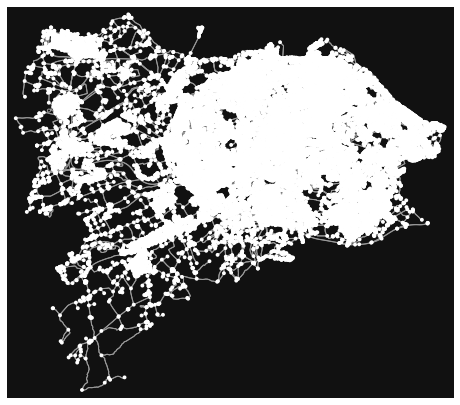

In [29]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

# Specify the name that is used to seach for the data
# place_name = "Bruntsfield, Edinburgh, Scotland"
place_name = "Edinburgh, Scotland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)
# Plot the streets
fig, ax = ox.plot_graph(graph)

In [68]:
ox. gdfs_from_graph(graph)

AttributeError: module 'osmnx' has no attribute 'gdfs_from_graph'

# Get some specific info from OSM

(The outdated queries in the course have been updated as per changelog here: https://github.com/gboeing/osmnx/issues/526)

#### Bicycle lanes

As advised here: https://help.openstreetmap.org/questions/64879/get-all-bicycle-infrastructure-for-a-city

<blockquote>
To get all cycle infrastructure you will need to retrieve at least:
    <ul>
<li>all roads that have additional tags indicating cycle infrastructure (cycleway=lane and cycleway=track)</li>
<li>all highway=cycleway</li>
<li>all highway=footway and highway=path that allow bicycle use or are intended for such (bicycle=yes, bicycle=designated, bicycle=official)</li>
    </ul>
</blockquote>

#### Roads and highways

In [30]:
tags={'highway':True}
highways = ox.geometries_from_place(place_name, tags)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


#### How to extract the bike lanes from this?

In [31]:
import numpy as np

bicycle_filters = []

for column in ['cycleway', 'cycleway:left', 'cycleway:right', 'cycleway:both']:
    if column not in highways.columns: continue
    bicycle_filters.append(highways[column]=='lane')

bicycle_filters.append(highways['highway']=='cycleway')
bicycle_filters.append(highways['bicycle']=='designated')
bicycle_filters=np.array(bicycle_filters)
bicycle_filters=np.any(bicycle_filters, axis=0)

#### Restaurants

In [32]:
tags = {'amenity':True, 'landuse':['restaurant']}
restaurants = ox.geometries_from_place(place_name, tags)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute 

#### Buildings

In [33]:
tags = {'building':True}
buildings = ox.geometries_from_place(place_name, tags=tags)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute 

#### Bicycle rentals

In [34]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

df_stations = pd.read_csv('df_stations.csv')
df_stations['geometry'] = df_stations[['station_lon','station_lat']].apply(lambda x : Point(*x), axis=1)
df_stations=gpd.GeoDataFrame(df_stations)
df_stations.crs = CRS.from_epsg(4326)

In [35]:
# Get the bike rentals in the specific neighbourhood we are looking at now
tags = {'amenity':'bicycle_rental'}
bike_stations = ox.geometries_from_place(place_name, tags)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


#### Parks and green spaces

In [36]:
tags = {'leisure':True}
leisure = ox.geometries_from_place(place_name, tags)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [37]:
nodes, edges = ox.graph_to_gdfs(graph)

In [38]:
from pyproj import CRS

# Set projection
projection = CRS.from_epsg(3067)

# Re-project layer
edges = edges.to_crs(projection)
buildings = buildings.to_crs(projection)
restaurants = restaurants.to_crs(projection)
leisure = leisure.to_crs(projection)
highways = highways.to_crs(projection)
bike_stations = bike_stations.to_crs(projection)
df_stations = df_stations.to_crs(projection)

KeyboardInterrupt: 

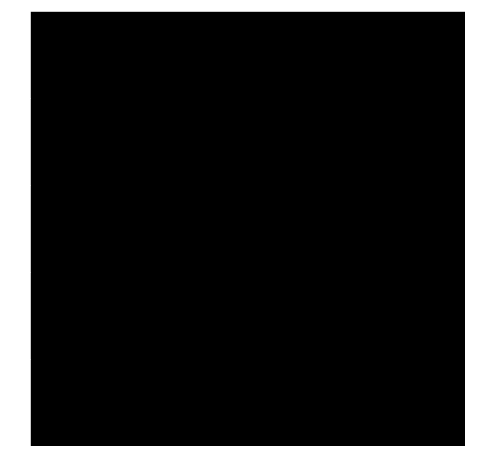

In [39]:
fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# AREAS
# Plot buildings
buildings.plot(ax=ax, facecolor='silver', alpha=0.7)
# Plot churches
restaurants[restaurants.amenity=='place_of_worship'].plot(ax=ax, color='purple', alpha=.7, markersize=10)
# Plot parks
leisure.plot(ax=ax, color='green', alpha=0.3, markersize=10)

# LINES
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
# Plot cycle ways
highways[bicycle_filters].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

# POINTS
# Plot restaurants
restaurants[restaurants.amenity=='restaurant'].plot(ax=ax, color='orange', alpha=1, markersize=10)
# Plot cafes
restaurants[restaurants.amenity=='cafe'].plot(ax=ax, color='brown', alpha=1, markersize=10)
# Plot fast food
restaurants[restaurants.amenity=='fast_food'].plot(ax=ax, color='red', alpha=1, markersize=10)
# Plot JustEat stations in cyan; 
bike_stations.plot(ax=ax, color='cyan', alpha=1, markersize=50)

plt.axis('off')

plt.tight_layout()

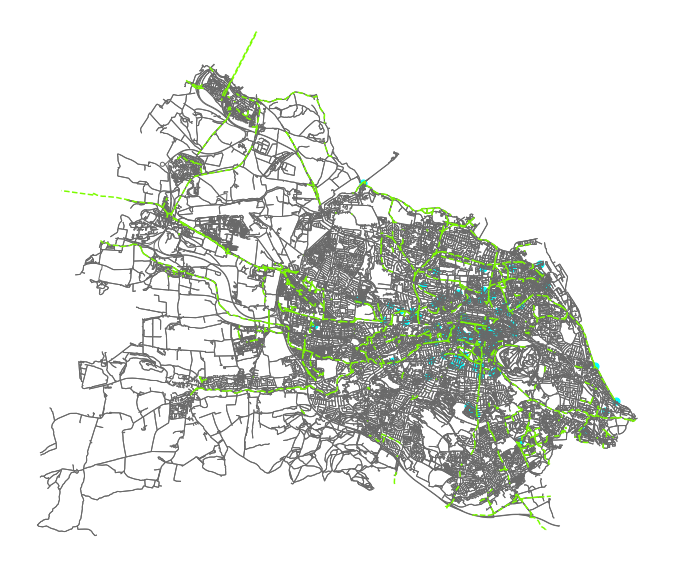

In [40]:
fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# LINES
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
# Plot cycle ways
highways[bicycle_filters].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

# POINTS
# Plot JustEat stations in cyan; 
bike_stations.plot(ax=ax, color='cyan', alpha=1, markersize=50)

plt.axis('off')

plt.tight_layout()

# Path from a bike rental to the next

Let's see if we can plot a trip from one station to the next.

Now we will need some sort of metric system; therefore we need to project our graph: As the data is in WGS84 format, we should first reproject our data into a metric system. We can re-project the graph from latitudes and longitudes to an appropriate UTM zone:

In [41]:
graph_proj = ox.project_graph(graph)

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
# Project the bike stations int our dataset in the same coordinates system
bike_stations_proj = bike_stations.to_crs(nodes_proj.crs)
# Project all bike stations in the same coordinates system
df_stations_proj = df_stations.to_crs(nodes_proj.crs)

print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


# Map a bike factor through Edinburgh

### Map each bicycle rental in the Just Eat Dataset to its equivalent in the OSM data

In [42]:
def find_closest(p, df):
    return df.loc[df.geometry.apply(lambda x : x.distance(p)).idxmin()].station_id

bike_stations_proj['JustEat_id'] = bike_stations_proj.geometry.apply(lambda p : find_closest(p, df_stations_proj))

In [43]:
factor_trips = pd.read_csv('factor_trips.csv')[['start_station_id', 'end_station_id', 'intensity']]

filter_1 = factor_trips.start_station_id.isin(bike_stations_proj.JustEat_id)
filter_2 = factor_trips.end_station_id.isin(bike_stations_proj.JustEat_id)

factor_trips = factor_trips[filter_1 & filter_2]

JustEat_coords = bike_stations_proj.set_index('JustEat_id').geometry.to_dict()

factor_trips['start_geo'] = factor_trips.start_station_id.apply(lambda x : JustEat_coords[x])
factor_trips['end_geo'] = factor_trips.end_station_id.apply(lambda x : JustEat_coords[x])

factor_trips.intensity = factor_trips.intensity/factor_trips.intensity.max()

factor_trips = gpd.GeoDataFrame(factor_trips)

KeyboardInterrupt: 

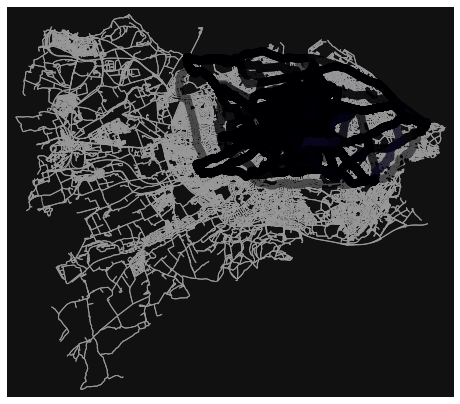

In [44]:
# Precious help from: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')

routes=[]
rc=[]
i=0

for r in factor_trips.iterrows():
    row = r[1]
        
    orig_node = ox.distance.nearest_nodes(graph_proj, *row.start_geo.xy)
    target_node = ox.distance.nearest_nodes(graph_proj, *row.end_geo.xy)
    
    routes.append(nx.shortest_path(G=graph_proj, 
                             source=orig_node[0],
                             target=target_node[0],
                             weight='length'))
    
    color = '#%02x%02x%02x' % cmap(row.intensity, bytes=True)[:-1]
    rc.append(color)
    i+=1
    print(i)

KeyboardInterrupt: 

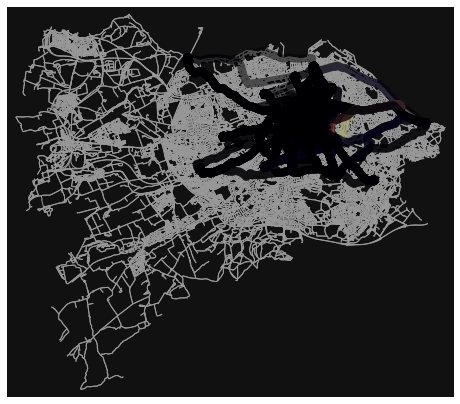

In [63]:
fig, ax = ox.plot_graph_routes(graph_proj, routes, route_colors=rc, node_size=0, route_linewidths=8)